In [1]:
%load_ext autoreload

In [2]:
%autoreload
import utilhysplit

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
import geopandas

In [4]:
from utilhysplit import parutils

In [5]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from monetio.models import hysplit

In [6]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
import utilvolc.ash_eval as ae
from utilvolc import volcMER
from utilhysplit.evaluation import ensemble_tools
from utilhysplit.evaluation import plume_stat
import cases

In [7]:
%autoreload
case = cases.runA()
print(case)
tag = case.vhash['tag']
tdir = case.vhash['tdir']
tname = case.vhash['tname']
configdir= case.vhash['configdir']
configfile = case.vhash['configfile']
vdir = case.vhash['vdir']
vid = case.vhash['vid']
gdir = case.vhash['gdir']
graphicstype = case.vhash['graphicstype']
vloc = case.vhash['vloc']

vloc : [160.587, 55.978]
tag : A
tdir : ../data/
tname : xrfile.ensCylBezy.nc
configdir : ../RunA
configfile : config.ensCylBezy.txt
vdir : ../data/volcat/
vid : v300250
gdir : ./graphics/
graphicstype : png



In [8]:
test = xr.open_dataset(os.path.join(case.vhash['tdir'],case.vhash['tname']))

In [9]:
test.longitude.values

array([[156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696],
       [156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696],
       [156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696],
       ...,
       [156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696],
       [156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696],
       [156.48569489, 156.58569336, 156.68569183, ..., 184.98526001,
        185.08525848, 185.18525696]])

In [10]:
%autoreload
ensemble_tools.preprocess(test)

(<xarray.Dataset>
 Dimensions:    (ens: 31, time: 24, x: 288, y: 235, z: 9)
 Coordinates:
   * x          (x) int64 860 861 862 863 864 865 ... 1143 1144 1145 1146 1147
   * y          (y) int64 302 303 304 305 306 307 308 ... 531 532 533 534 535 536
   * z          (z) int64 1523 3047 4571 6095 7619 9143 10667 12191 13715
   * ens        (ens) object 'gec00' 'gep01' 'gep02' ... 'gep28' 'gep29' 'gep30'
   * time       (time) datetime64[ns] 2020-10-21T20:00:00 ... 2020-10-22T19:00:00
     source     <U13 'Line to 13 km'
     latitude   (y, x) float64 ...
     longitude  (y, x) float64 156.5 156.6 156.7 156.8 ... 185.0 185.1 185.2
 Data variables:
     p060       (ens, time, z, y, x) float32 ...,
 'ens')

In [11]:
%autoreload
aeval = ae.AshEval(tdir,tname,vdir,vid,configdir=configdir,configfile=configfile)

In [12]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,22,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(1,16):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 22, 12, 0), datetime.datetime(2020, 10, 22, 13, 0)]


In [13]:
'mult' in aeval.cdump.attrs

True

In [14]:
1.5e4 * 0.20

3000.0

In [15]:
%autoreload
# For the cylindrical source change the MER.
if 'mult' in aeval.cdump.attrs:
    xmult = aeval.cdump.mult
    print('{:2e}'.format(xmult))
    # convert unit mass using the 15000 kg/s from volcat.
    from utilvolc import volcMER
    cmult = volcMER.MER2unit(1.5e4,1)
    print('Using 15000 kg/s: unit mass =  {:2e} g/hr'.format(cmult[0]))
    cmult = cmult[0] 
    # divide by the old conversion factor and multiply by the new one.
    # Note that this does not change the cdump attribute but only affects output.
    aeval.set_concmult(cmult/xmult)
    orig_mult = cmult/xmult
else:
    aeval.set_concmult(1)
aeval.concmult
biastag = ''

7.153737e+12
Using 15000 kg/s: unit mass =  5.400000e+10 g/hr


In [16]:
aeval.set_concmult(aeval.concmult*0.2)
biastag = 'bc0p2'

In [17]:
aeval.concmult

0.0015097004052409524

In [18]:
# time averages observations
# matches observations and model forecast to the same domain.
# these are stored in dictionaries.
%autoreload
d1 = datetime.datetime(2020,10,22,1)
d2 = datetime.datetime(2020,10,22,2)
for drange in dlist:
    print(drange)
    aeval.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]
[datetime.datetime(2020, 10, 22, 7, 0), datetime.datetime(2020, 10, 22, 8, 0)]
[datetime.datetime(2020, 10, 22, 8, 0), datetime.datetime(2020, 10, 22, 9, 0)]
[datetime.datetime(2020, 10, 22, 9, 0), datetime.datetime(2020, 10, 22, 10, 0)]
[datetime.datetime(2020, 10, 22, 10, 0), datetim

In [19]:
# time periods available.
aeval.volcat_avg_hash.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [20]:
#ht = 6.2
ht = 9.0
vent = 2.88
m63 = 0.1
dmult = volcMER.HT2unit(ht-vent,m63)
print('Height of {}km: unit mass = {:2e}'.format(ht,dmult))

HEIGHT 6.1 km,  MER 2.590e+05 kg/s , M63 0.100000 , unit mass=9.326e+10 g/hr.
Height of 9.0km: unit mass = 9.325757e+10


In [21]:
%autoreload
# this will utilize the self.concmult set earlier.
aeval.calc_massload()

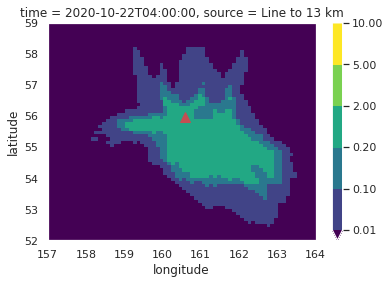

In [22]:
sns.set()
levels=[0.01,0.1,0.2,2,5,10]
vmin=0.02
vmax=5
cmap='viridis'
aeval.massload.mean(dim='ens').isel(time=8).plot.pcolormesh(x='longitude',y='latitude',levels=levels,cmap=cmap)
ax = plt.gca()
ax.set_xlim(157,164)
ax.set_ylim(52,59)
plt.plot(vloc[0],vloc[1],'r^',MarkerSize=10)
plt.savefig('traditional_source_{}.png'.format(biastag))

# Fractions Skill Score FSS, MAE, and MSE

In [ ]:
%autoreload
volcat=[]
forecast=[]
pixel_match=False
threshold=2
# get_pair will return the cdump multiplied by the concmult factor set earlier.
# get these times.
for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
#for tii in [2,3]:
    obs, model = aeval.get_pair(tii)
    forecast.append(model)
    volcat.append(obs)

# dft is a pandas dataframe with FSS information
# dft2 is pandas dataframe with MSE, MAE information.
dft, dft2 = ensemble_tools.ens_time_fss(forecast,volcat,threshold=threshold,
                                  neighborhoods=[1,3,5,7,9,11,13,15,17,19,21],plot=False,
                                  pixel_match=pixel_match)
print(dft.columns)
if pixel_match: pmtag = '_pm'
else: pmtag=''

In [ ]:
#  MAE, MSE, RMSE as function of time.
%autoreload
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_ens_accuracy(dft2,'MAE')
plt.savefig(gdir + 'run{}_mae_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'MSE')
plt.savefig(gdir + 'run{}_mse_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'RMSE')
plt.savefig(gdir + 'run{}_rmse_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'fractional_bias')
plt.savefig(gdir + 'run{}_FB_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'bias')
plt.savefig(gdir + 'run{}_bias_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'CSI')
plt.savefig(gdir + 'run{}_CSI_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'POD')
plt.savefig(gdir + 'run{}_POD_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))
plt.show()
ensemble_tools.plot_ens_accuracy(dft2,'FAR')
plt.savefig(gdir + 'run{}_FAR_ts_t{}{}{}.{}'.format(tag,threshold,pmtag,biastag,graphicstype))

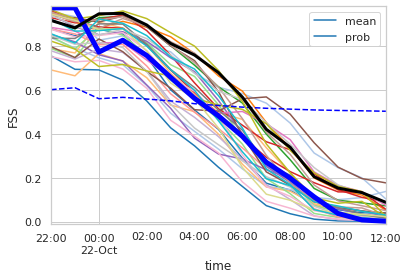

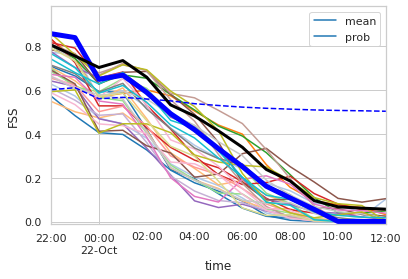

In [190]:
# FSS at one neightborhood size as a function of time.
# different colored lines are the different ensemble members.
# Uses output from the cell above.
%autoreload
sns.set()
sns.set_style('whitegrid')
# grid size is 0.1 degrees.
# neighborhood gives the number of grid squares to
# look at. 10 would be a 1degree x 1 degree area.
neighborhood = 13
ensemble_tools.plot_ens_fss_ts(dft,nval=neighborhood)
ax = plt.gca()
ax.set_ylim(-0.01,0.98)
plt.savefig(gdir + 'run{}_fss_ts_n{}_t{}{}{}.{}'.format(tag,neighborhood,threshold,pmtag,biastag,graphicstype))
neighborhood = 3
ensemble_tools.plot_ens_fss_ts(dft,nval=neighborhood)
ax = plt.gca()
ax.set_ylim(-0.01,0.98)
plt.savefig(gdir + 'run{}_fss_ts_n{}_t{}{}{}.{}'.format(tag,neighborhood,threshold,pmtag,biastag,graphicstype))
# 0.25 degree resolution for ICAO. 
# 3 neighborhood size is a 0.3 degree. 

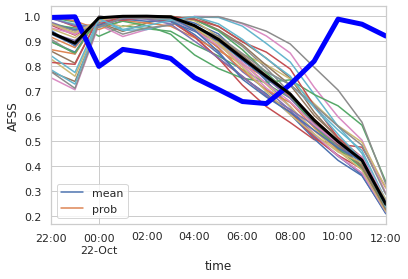

In [26]:
# plots the AFSS which is a measure of frequency bias as a function of time.
# The FSS will approach this value as neighborhood size approaches domain size.
# When pixel matching is used, this will always be 1.
%autoreload
afss = ensemble_tools.plot_afss_ts(dft)
# no reason to save if pixel matching is True.
if not pixel_match:
    plt.savefig(gdir + 'run{}_afss_ts_t{}{}.{}'.format(tag,threshold,biastag,graphicstype))
else:
    print('pixel match on')

# Look at one time period, different neighbhorhood sizes.

In [199]:
# Look at one time period, different neighbhorhood sizes.
%autoreload
tii=10
pixel_match=False
threshold=0.2
threshstr = str(threshold).replace('.','p')
timeval = aeval.cdump.time.values[tii]
print(timeval)
volcat,forecast = aeval.get_pair(tii)
print(aeval.concmult)
#forecast = aeval.cdump_hash[tii]
nb = np.arange(1,21,2)
nb = np.append(nb,[31,41,51])
if tii > 8:
    nb = np.append(nb,[61,71,81,91,101])
#nb = [11,81,91]
# msc and psc are CalcScores objects.
# msc is for the ensemble mean (deterinistic)
# psc is for the probabilistic model field.
msc, psc, df1, dfmae = ensemble_tools.ens_fss(forecast,volcat,threshold=threshold,
                                       neighborhoods=nb,
                                       return_objects=True,plot=False,
                                       pixel_match=pixel_match)
plt.show()
if pixel_match: pmtag='_pm'
else: pmtag = ''

2020-10-22T06:00:00.000000000
0.0015097004052409524


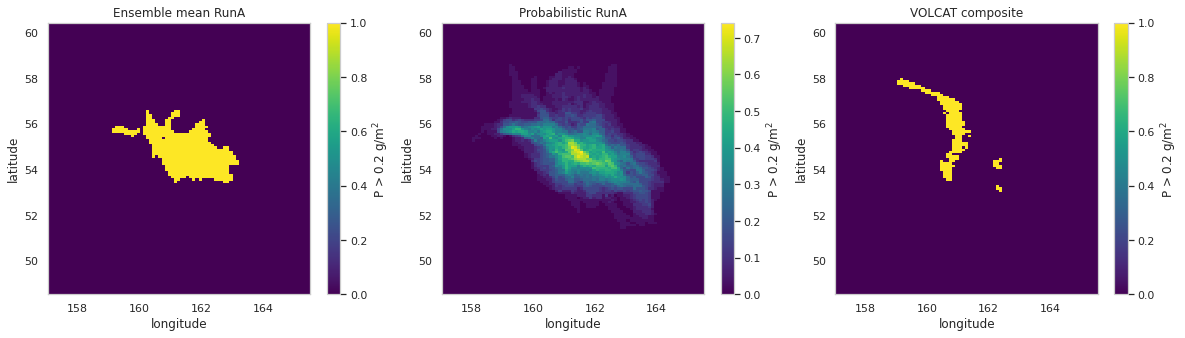

In [200]:
# Plots of 
fig = plt.figure(1,figsize=[20,5])
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
chash = {'label': 'P > {} g/m$^2$'.format(threshold)}
msc.binxra2.plot.pcolormesh(ax=ax1,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra2.plot.pcolormesh(ax=ax2,x='longitude',y='latitude', cbar_kwargs=chash)
psc.binxra1.plot.pcolormesh(ax=ax3,x='longitude',y='latitude',cbar_kwargs=chash)
ax1.set_title('Ensemble mean Run{}'.format(tag))
ax2.set_title('Probabilistic Run{}'.format(tag))
ax3.set_title('VOLCAT composite')
timeval = pd.to_datetime(timeval)
timestr = timeval.strftime("%Y%m%dT%H")
timeval2 = timeval + datetime.timedelta(hours=1)
timestr2 = timeval2.strftime("T%H")
plt.savefig(gdir + 'binary_fields_run{}_t_{}_{}_{}{}{}'.format(tag,threshstr,timestr,timestr2,pmtag,biastag))

[0.52076125]


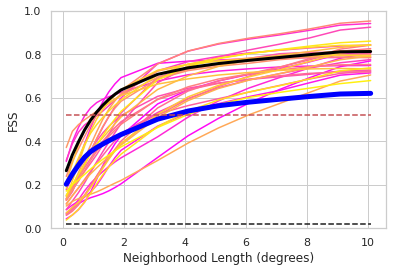

In [201]:
%autoreload
sns.set()
sns.set_style('whitegrid')
print(df1['uniform'].unique())
ensemble_tools.plot_ens_fss(df1,sizemult=0.1)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_ylabel('FSS')
#ax.set_xlim(1,5)
ax.set_xlabel('Neighborhood Length (degrees)')
plt.savefig(gdir + 'FSS_run{}_t{}_{}_{}_{}'.format(tag, threshstr, timestr,timestr2,biastag))

In [202]:
df1[df1.ens=='mean']

Nlen       FBS   FBS_ref       FSS    random   uniform      afss   ens  \
1       1  0.060702  0.076125  0.202597  0.020761  0.520761  0.657534  mean   
3       3  0.046800  0.062389  0.249863  0.020761  0.520761  0.657534  mean   
5       5  0.039000  0.054982  0.290666  0.020761  0.520761  0.657534  mean   
7       7  0.033320  0.049484  0.326644  0.020761  0.520761  0.657534  mean   
9       9  0.029205  0.045135  0.352957  0.020761  0.520761  0.657534  mean   
11     11  0.026079  0.041503  0.371630  0.020761  0.520761  0.657534  mean   
13     13  0.023457  0.038306  0.387640  0.020761  0.520761  0.657534  mean   
15     15  0.021133  0.035389  0.402857  0.020761  0.520761  0.657534  mean   
17     17  0.019052  0.032697  0.417299  0.020761  0.520761  0.657534  mean   
19     19  0.017173  0.030192  0.431223  0.020761  0.520761  0.657534  mean   
31     31  0.009235  0.018536  0.501763  0.020761  0.520761  0.657534  mean   
41     41  0.005871  0.012743  0.539264  0.020761  0.520761  0.657534  mean   
51     51  0.004000  0.009165  0.563615  0.020761  0.520761  0.657534  mean   
61     61  0.002879  0.006859  0.580280  0.020761  0.520761  0.657534  mean   
71     71  0.002150  0.005289  0.593560  0.020761  0.520761  0.657534  mean   
81     81  0.001629  0.004139  0.606339  0.020761  0.520761  0.657534  mean   
91     91  0.001242  0.003249  0.617609  0.020761  0.520761  0.657534  mean   
101   101  0.000963  0.002537  0.620598  0.020761  0.520761  0.657534  mean   

                   time  length (degrees)  
1   2020-10-22 06:00:00               0.1  
3   2020-10-22 06:00:00               0.3  
5   2020-10-22 06:00:00               0.5  
7   2020-10-22 06:00:00               0.7  
9   2020-10-22 06:00:00               0.9  
11  2020-10-22 06:00:00               1.1  
13  2020-10-22 06:00:00               1.3  
15  2020-10-22 06:00:00               1.5  
17  2020-10-22 06:00:00               1.7  
19  2020-10-22 06:00:00               1.9  
31  2020-10-22 06:00:00               3.1  
41  2020-10-22 06:00:00               4.1  
51  2020-10-22 06:00:00               5.1  
61  2020-10-22 06:00:00               6.1  
71  2020-10-22 06:00:00               7.1  
81  2020-10-22 06:00:00               8.1  
91  2020-10-22 06:00:00               9.1  
101 2020-10-22 06:00:00              10.1

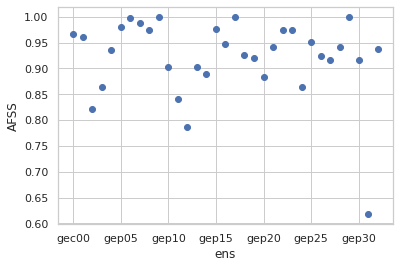

In [31]:
sns.set()
sns.set_style('whitegrid')
ensemble_tools.plot_afss(df1)
plt.savefig(gdir + 'AFSS_run{}_t{}_{}_{}_{}'.format(tag, threshstr, timestr,timestr2,biastag))

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = asanyarray(y)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asanyarray(x)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

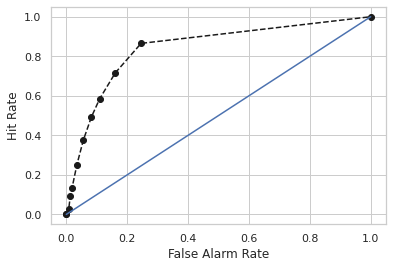

In [32]:
# Calculate ROC curve using 
%autoreload
xlist, ylist, area = psc.calc_roc(clip=True)
plume_stat.plot_roc(xlist,ylist)
threshstr = str(threshold).replace('.','p')
plt.savefig(gdir + 'ROC_run{}_t{}_{}_{}{}'.format(tag,threshstr, timestr,timestr2,biastag))

# Visual comparison

2020-10-22T00:00:00.000000000
gep15
tii 4


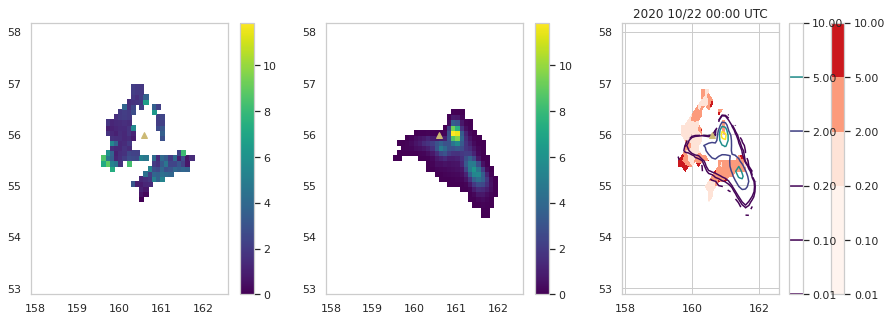

gep15
tii 4


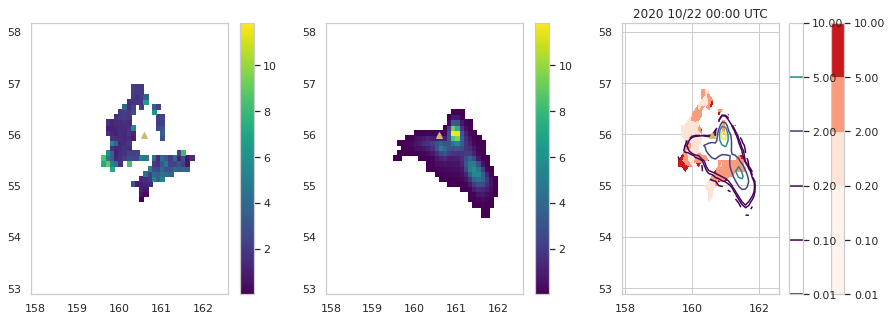

gep19
tii 4


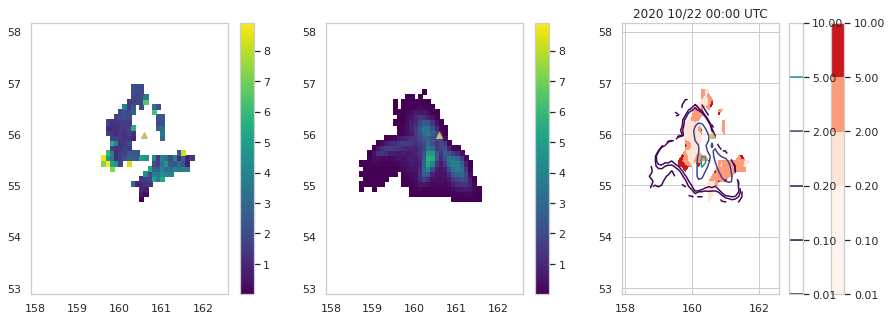

gep26
tii 4


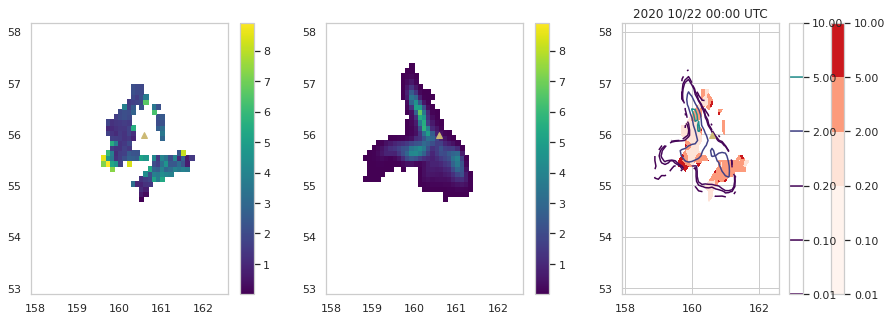

gep05
tii 4


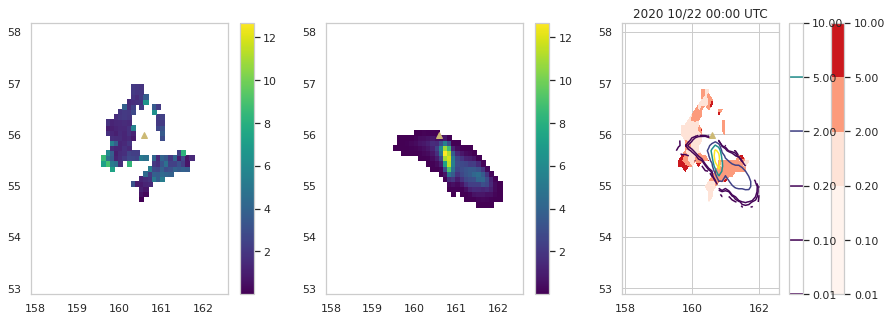

gec00
tii 4


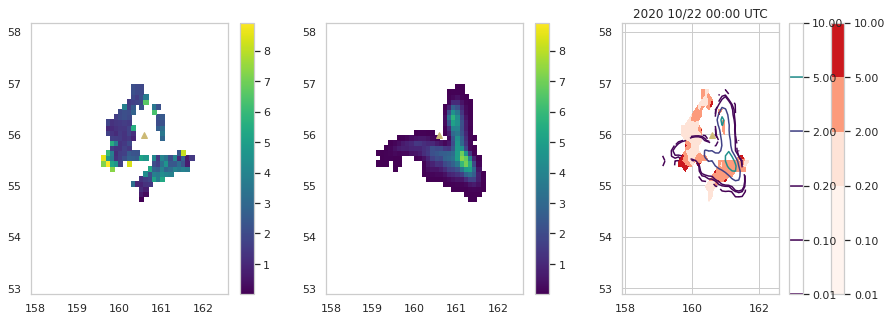

tii 4


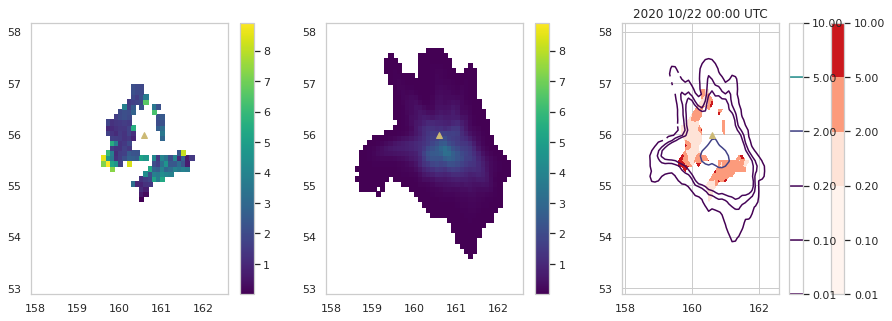

tii 4


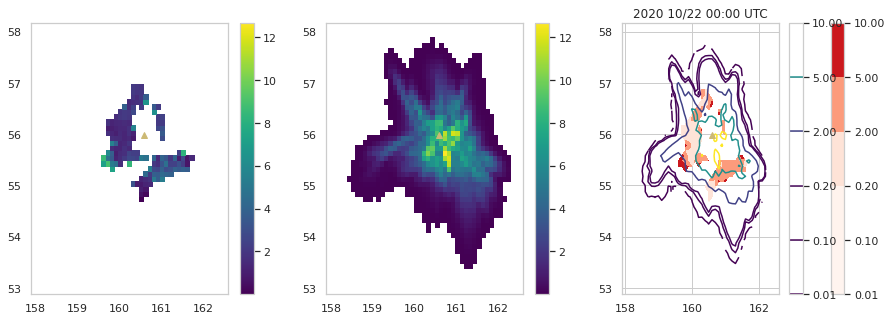

In [33]:
%autoreload
tii = 4  # time period
print(aeval.massload.time.values[tii])
# Comparison of some of the different ensemble members
for ens in ['gep15', 'gep15','gep19','gep26','gep05','gec00']:
    print(ens)
    fig = aeval.compare_forecast(aeval.massload.sel(ens=ens).isel(time=tii),vloc=vloc)

    plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_{}.png'.format(tag,threshstr, timestr,timestr2,ens))
    plt.show()
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep05').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep10').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gep15').isel(time=tii),vloc=vloc)
#plt.show()
#fig = aeval.compare_forecast(aeval.massload.sel(ens='gec00').isel(time=tii),vloc=vloc)
#plt.show()
# mean of ensemble
fig = aeval.compare_forecast(aeval.massload.mean(dim='ens').isel(time=tii),vloc=vloc)
plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_ensmean.png'.format(tag,threshstr, timestr,timestr2))
plt.show()
# maximum of ensemble
fig = aeval.compare_forecast(aeval.massload.max(dim='ens').isel(time=tii),vloc=vloc)
plt.savefig(gdir + 'pcolormesh_run{}_t{}_{}_{}_ensmax.png'.format(tag,threshstr, timestr,timestr2))

# Comparing CDF

['2020-10-21T20:00:00.000000000' '2020-10-21T21:00:00.000000000'
 '2020-10-21T22:00:00.000000000' '2020-10-21T23:00:00.000000000'
 '2020-10-22T00:00:00.000000000' '2020-10-22T01:00:00.000000000'
 '2020-10-22T02:00:00.000000000' '2020-10-22T03:00:00.000000000'
 '2020-10-22T04:00:00.000000000' '2020-10-22T05:00:00.000000000'
 '2020-10-22T06:00:00.000000000' '2020-10-22T07:00:00.000000000'
 '2020-10-22T08:00:00.000000000' '2020-10-22T09:00:00.000000000'
 '2020-10-22T10:00:00.000000000' '2020-10-22T11:00:00.000000000'
 '2020-10-22T12:00:00.000000000' '2020-10-22T13:00:00.000000000'
 '2020-10-22T14:00:00.000000000' '2020-10-22T15:00:00.000000000'
 '2020-10-22T16:00:00.000000000' '2020-10-22T17:00:00.000000000'
 '2020-10-22T18:00:00.000000000' '2020-10-22T19:00:00.000000000']


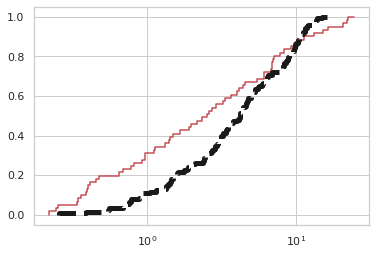

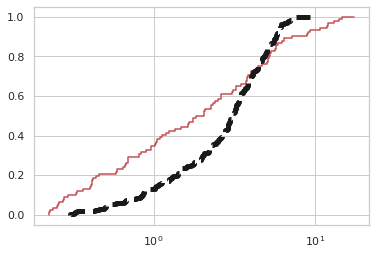

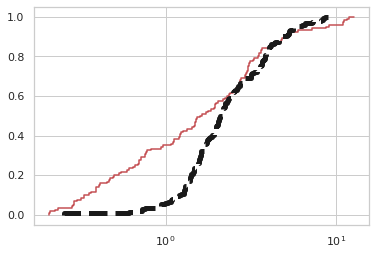

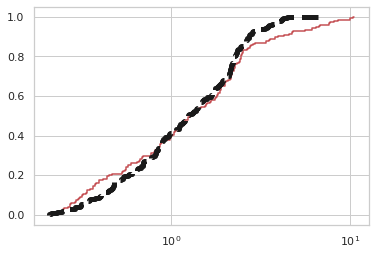

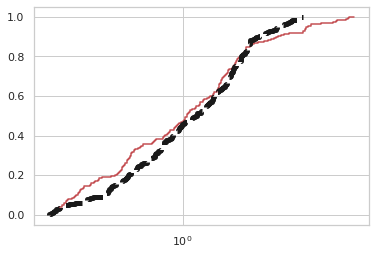

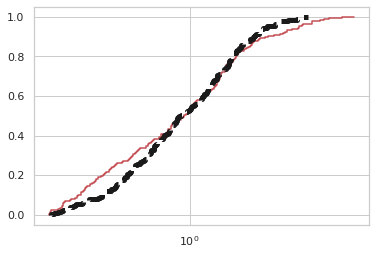

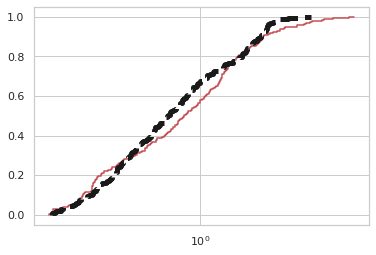

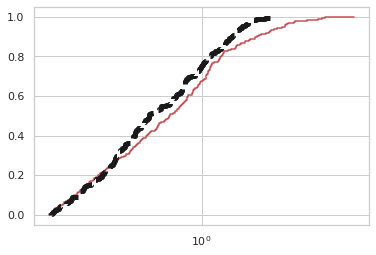

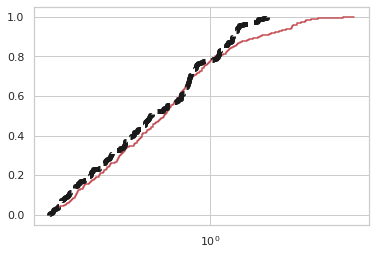

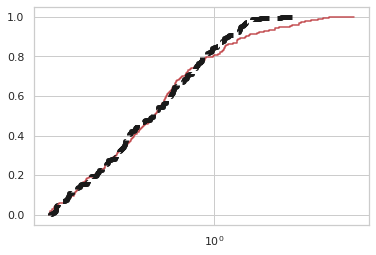

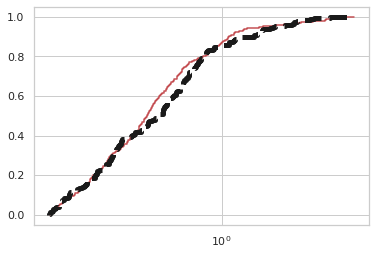

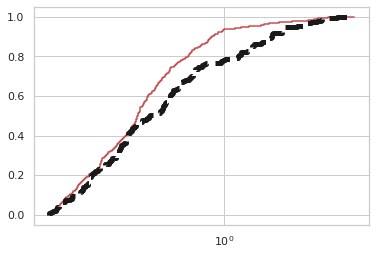

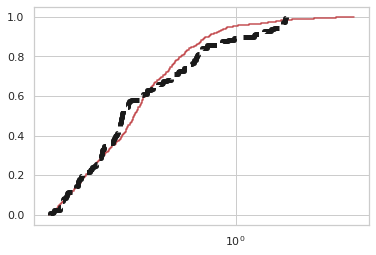

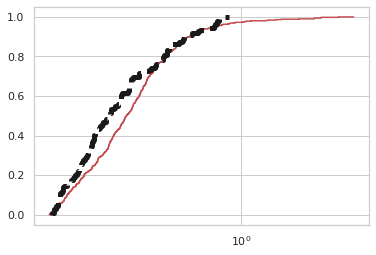

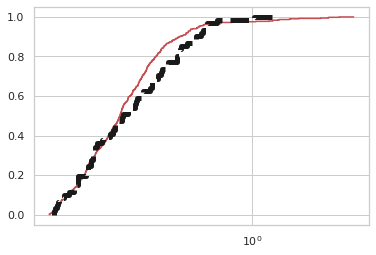

<Figure size 432x288 with 0 Axes>

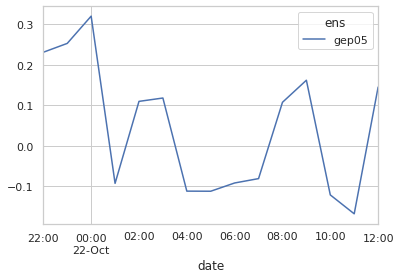

In [34]:
%autoreload
# one ensemble member at all times.
tii=5
timelist = aeval.massload.time.values
enslist = aeval.massload.ens.values
enslist = [enslist[tii]]
#timelist = [aeval.massload.time.values[tii]]
print(timelist)
#print(enslist)
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=False
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
ax = plt.gca()
#add_lines(ax)
plt.show()
#use_pixel_match=False
#kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match)
#ax = plt.gca()
#add_lines(ax)

In [35]:
#SET THE TIME
d1 = datetime.datetime(2020,10,22,10)
timestr = d1.strftime("%Y%m%dT%H")

[datetime.datetime(2020, 10, 22, 10, 0)]
saving pixel_match_cdf_A_20201022T10bc0p2.png


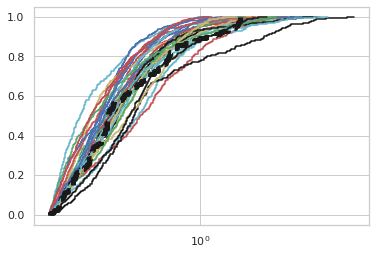

<Figure size 432x288 with 0 Axes>

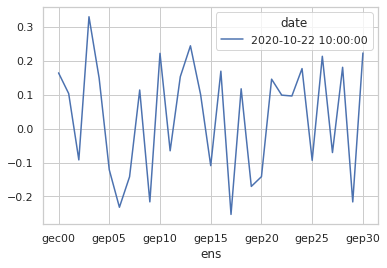

saving cdf_A_20201022T10bc0p2.png


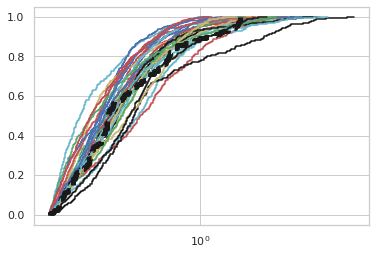

<Figure size 432x288 with 0 Axes>

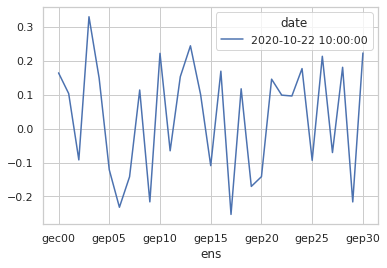

In [36]:
%autoreload
# CDF for all ensemble members at one time.
enslist = aeval.massload.ens.values
enslist = None
timelist=[d1]
print(timelist)
#print(enslist)l.
threshold = 0.2
# CDF with pixel matching. Threshold will be different for every ensemble member as well as fo
# volcat data. First threshold is applied to VOLCAT data. Number of VOLCAT pixels above threshold
# is counted.
use_pixel_match=False
figname = 'pixel_match_cdf_{}_{}{}.png'.format(tag,timestr,biastag)
aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match,figname=figname)
ax = plt.gca()
plt.savefig(gdir + 'pixel_match_ks_{}_{}{}.png'.format(tag,timestr,biastag))
#add_lines(ax)
plt.show()
# CDF with no pixel matching. Thresholds are the same for every ensemble member and volcat data.
# number of above threshold pixels will be different.
use_pixel_match=False
figname = 'cdf_{}_{}{}.png'.format(tag,timestr,biastag)
kslist = aeval.mass_cdf_plot(timelist,enslist,threshold=threshold,use_pixel_match=use_pixel_match,figname=figname)
ax = plt.gca()
plt.savefig(gdir + 'ks_{}_{}{}.png'.format(tag,timestr,biastag))
#add_lines(ax)


# ROC diagrams

In [37]:
%autoreload
problist = []
dtlist = []
for tii in [4,6,8,10,12,14]:
    dtlist.append(aeval.get_time(tii))
    volcat,forecast = aeval.get_pair(tii)
    pm=False
    probscores = plume_stat.CalcScores(volcat, forecast,threshold=0.1,probabilistic=True,pixel_match=pm)
    problist.append(probscores)

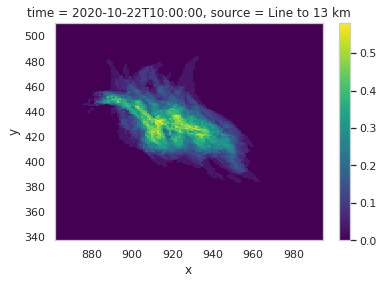

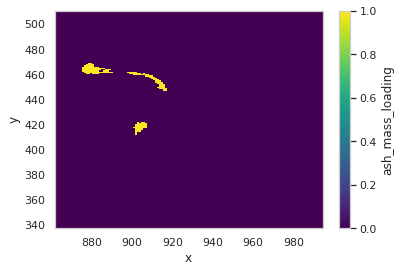

In [38]:
xii=-1
problist[xii].binxra2.plot.pcolormesh()
plt.show()
problist[xii].binxra1.plot.pcolormesh()
#plt.plot(vloc[0],vloc[1],'r^',MarkerSize=10)

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = asanyarray(y)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asanyarray(x)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

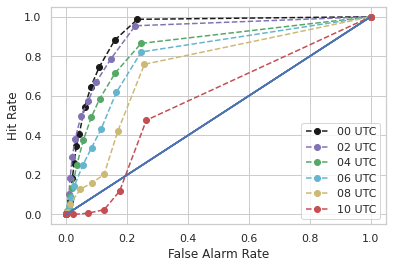

In [39]:
%autoreload
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
clr = ['--ko','--mo','--go','--co','--yo','--ro']
clip = True
if clip : cliptag = 'clip'
else: cliptag = ''
for iii, prob in enumerate(problist):
    label = dtlist[iii].strftime("%H UTC")
    xlist, ylist, area = prob.calc_roc(clip=True)
    plume_stat.plot_roc(xlist,ylist,ax=ax,clr=clr[iii],label=label)
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles,labels)
plt.savefig(gdir + 'ROC_run{}_{}{}.png'.format(tag,biastag,cliptag))
    

/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = asanyarray(y)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4219: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = asanyarray(x)
/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/numpy/lib/function_base.py:4215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tu

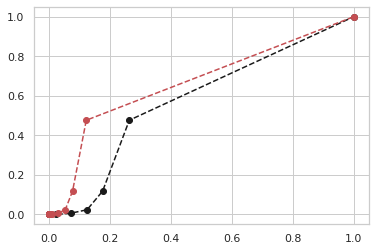

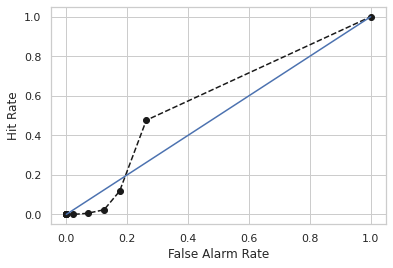

In [40]:
%autoreload
sns.set()
sns.set_style('whitegrid')
datedf1 = pd.to_datetime(aeval.cdump.time.values[tii])
timetag = datedf1.strftime("%Y%m%dT%H")
if pm: timetag + '_pm'

xlist, ylist, area = probscores.calc_roc(clip=True)
xlist2,ylist2, area = probscores.calc_roc(clip=False)
plt.plot(xlist,ylist,'--ko')
plt.plot(xlist2,ylist2,'--ro')
plt.show()
plume_stat.plot_roc(xlist,ylist)
#plt.savefig(gdir + 'ROC_run{}_{}{}.png'.format(tag,timetag,biastag))
#plume_stat.plot_roc(xlist2,ylist2)

# Reliability Curves

In [41]:
from utilhysplit.evaluation import reliability


In [42]:
aeval.concmult

0.0015097004052409524

In [43]:
tii = 12
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]*aeval.concmult

In [44]:
print(aeval.cdump.time.values[16])

2020-10-22T12:00:00.000000000


In [45]:
str.join('.',map(str,[1,2]))

'1.2'

In [46]:
aeval.get_time(2)

Timestamp('2020-10-21 22:00:00')

In [47]:
print(aeval.get_time(2))
print(aeval.get_time(5))
print('----')
print(aeval.get_time(6))
print(aeval.get_time(9))

print('----')
print(aeval.get_time(10))
print(aeval.get_time(13))

2020-10-21 22:00:00
2020-10-22 01:00:00
----
2020-10-22 02:00:00
2020-10-22 05:00:00
----
2020-10-22 06:00:00
2020-10-22 09:00:00


In [158]:
%autoreload
#tr=reliability.TestReliability()
#tr.test2(div=0.5)
#tr.test_random()

In [149]:
a = [1,2,3,4]
a.extend([4,5])
a

[1, 2, 3, 4, 4, 5]

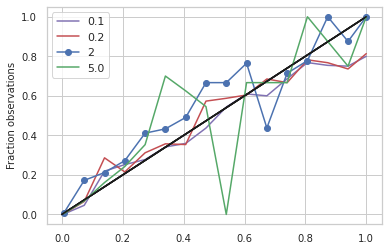

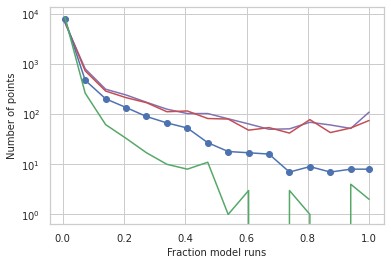

In [181]:
%autoreload
num=15  #number of bins to use on x axis.
# 

aeval.set_concmult(orig_mult*0.2)
biastag = 'bc0p2'


sns.set_style('whitegrid')
threshlist = [0.1,0.2,[0.1,2],2,[2,5],5.0]
threshlist = [0.1,0.2,2,5.0]
#threshlist = [[0,0.2],[0.2,2],[2,5],[5,10]]

#---------------------------------------------------------
## shows relationship between probability that c> 2 and
## probability that c < 2. 
## reflection about y=0.5 and x=0.5. 
## need to use 31 bins to see perfect symetry.
# num=31
# threshlist = [[0,1.99999],[2,20]]
#----------------------------------------------------------

clrs = ['-m','-r','-bo','-g','-co','-y']
rclist = []
labels = []
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1,1,1)

# create a ReliabilityCurve object for each threshold.
for thresh in threshlist:
    if isinstance(thresh,(float,int)):
        labels.append(str(thresh))
    else:
        labels.append('{} to {}'.format(thresh[0],thresh[1]))
    rclist.append(reliability.ReliabilityCurve(thresh,num))
# time periods to include in reliability diagram.

#tlist = [2,3,4,5,6,7,8]
tlist = [9,10,11,12,13,14,15,16]
#tlist = [10,11,12,13]
#tlist = [6,7,8,9]
tlist = [2,3,4,5]
#tlist = [10,11,12,13]
for tii in tlist:
#for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]*aeval.concmult
    for jjj, rc in enumerate(rclist):
        dfin = rc.reliability_add_xra(volcat,forecast,fill=True)

for jjj, rc in enumerate(rclist):
    reliability.sub_reliability_plot(rc,ax,clr=clrs[jjj],fs=10,label=labels[jjj])
    reliability.sub_reliability_number_plot(rc,ax2,clr=clrs[jjj],fs=10,label=labels[jjj])


    
rel_time_str = str.join('_',map(str,tlist))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc='upper left')

fig.savefig(gdir + 'reliability_{}_t{}{}'.format(tag,rel_time_str,biastag))
fig2.savefig(gdir + 'reliability_number_{}_t{}{}'.format(tag,rel_time_str,biastag))

In [170]:
xxx,yyy,nnn,yesval,noval = rclist[0].get_binvals()
xx2,yy2,nn2,yesval2,noval2 = rclist[1].get_binvals()
print(np.array(nnn).sum(), np.array(nnn).sum())

9225 9225


In [171]:
print(rclist[0].binlist)
for key in rclist[0].binlist:
    print(key * 31, rclist[0].yeshash[key], rclist[0].nohash[key], rclist[1].yeshash[key],rclist[1].nohash[key])
#print(rclist[0].yeshash)
#print(rclist[1].yeshash)
# What does this mean?
# 0 model runs predict but there was still some observations. These are complete misses.
# For threshold 0 to 2: 3 times obs were 0 to 2 and 5880 times obs were outside this range.
# For threshold 2 to 20: 63 times obs were in this range. 8020 times they were outside this range.
# Does this make sense? 

# All model runs make the same prediction
# For threshold 0 to 2: this never happened.
# for threshold 2 to 20 : this happened once and observation as also in 2 to 20 range.

# we should note that if no model runs are predicting concentrations in 2 to 20 range. then
# all of them should be predicting in the 0 to 2 range. 


[0.0032258064516129032, 0.035483870967741936, 0.06774193548387096, 0.09999999999999999, 0.13225806451612904, 0.16451612903225807, 0.1967741935483871, 0.22903225806451613, 0.26129032258064516, 0.29354838709677417, 0.3258064516129032, 0.3580645161290323, 0.3903225806451613, 0.4225806451612903, 0.45483870967741935, 0.4870967741935484, 0.5193548387096774, 0.5516129032258064, 0.5838709677419354, 0.6161290322580645, 0.6483870967741935, 0.6806451612903225, 0.7129032258064516, 0.7451612903225806, 0.7774193548387096, 0.8096774193548386, 0.8419354838709676, 0.8741935483870967, 0.9064516129032257, 0.9387096774193547, 0.9709677419354839, 1]
0.1 0 6 63 8020
1.1 0 2 39 284
2.0999999999999996 1 6 43 110
3.0999999999999996 0 1 26 89
4.1000000000000005 0 5 17 71
5.1000000000000005 0 2 18 61
6.1 0 4 19 38
7.1 1 1 20 27
8.1 1 2 17 26
9.1 0 4 16 25
10.1 2 1 13 13
11.100000000000001 3 2 14 16
12.1 6 5 12 11
13.1 0 5 9 4
14.1 4 8 9 5
15.100000000000001 2 2 10 4
16.099999999999998 4 10 2 2
17.099999999999998

0.2


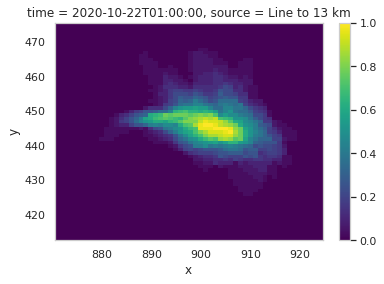

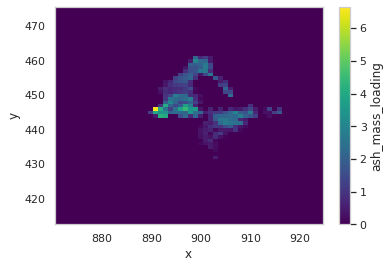

In [52]:
thresh=0.2
print(thresh)
prob = ensemble_tools.ATL(forecast,thresh=thresh,norm=True)
prob.plot.pcolormesh()
plt.show()
volcat.plot.pcolormesh()

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep05    0.000000
gep14    0.000000
gep07    0.000000
obs      0.000000
gep09    0.000000
gep10    0.000000
gep11    0.000000
gep12    0.000000
gep08    0.000000
gep04    0.001268
gep19    0.005078
gep13    0.015643
gep24    0.192998
Name: 887_447, dtype: float64
Rank 22 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep05    0.000000
gep14 

Rank 25 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep06    0.000000
gep07    0.000000
gep05    0.000000
gep09    0.000000
gep10    0.000000
gep08    0.000000
gep26    0.005228
gep19    0.023431
gep04    0.040607
gep11    0.164847
gep13    0.167412
gep24    0.190417
obs      1.329124
Name: 893_455, dtype: float64
Rank 31 1.329124093055725
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.00000

Rank 31 8.023921966552734
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep12    0.000000
gep15    0.000000
gep10    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep05    0.000000
gep06    0.000000
gep09    0.000000
gep28    0.001308
gep16    0.002610
gep08    0.028710
gep18    0.352630
gep07    0.561432
gep19    1.627943
gep30    1.942523
gep04    2.515193
gep13    2.875425
gep26    3.069230
gep24    3.265730
gep11    4.193718
obs      6.370780
Name: 896_453, dtype: float64
Rank 31 6.370779514312744
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep12    0.000000
gep15    0.000000
gep05    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep06    0.000000
ge

ROW ens
gep27     0.311745
gep17     1.140457
gep11     1.602928
gep03     1.606271
gep05     2.166227
gep14     2.189032
gep21     2.336962
gep01     3.093440
gep15     3.207404
gep25     3.437425
gep20     3.877547
gep09     4.265580
gec00     4.443131
gep28     4.646192
gep23     4.715171
gep02     4.807885
gep26     4.976843
gep12     5.069551
gep10     5.229540
gep22     5.824574
gep24     6.318257
gep18     7.353786
gep16     7.420381
gep04     8.824261
gep07     9.529110
gep19     9.709489
gep13     9.850565
gep29    10.698868
gep30    11.171233
gep06    12.545986
obs      13.258965
gep08    13.449024
Name: 899_449, dtype: float64
Rank 30 13.258965492248535
ROW ens
gep17     2.464348
gep05     2.586245
gep25     2.744215
gep27     2.948856
gep01     3.021619
gep03     3.156107
gep14     3.288603
gep28     3.437514
gep21     3.454080
gep10     3.813417
gep20     4.156100
gep15     4.300337
gec00     4.550879
gep11     4.656409
gep09     5.407300
gep23     5.754129
gep22     5.769

Rank 26 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep01    0.000000
gep03    0.000000
gep04    0.000000
gep05    0.000000
gep14    0.000000
gep07    0.000000
gep06    0.000000
gep09    0.000000
gep11    0.000000
gep12    0.000000
gep08    0.000000
obs      0.000000
gep10    0.002632
gep20    0.011909
gep02    1.319063
gep27    1.404398
Name: 901_458, dtype: float64
Rank 27 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.0

Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep05    0.000000
gep14    0.000000
obs      0.000000
gep09    0.000000
gep10    0.000000
gep11    0.000000
gep07    0.000000
gep08    0.001272
gep13    0.001272
gep28    0.005087
gep21    0.114375
gep12    1.492940
Name: 904_442, dtype: float64
Rank 22 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep07    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.0

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep26    0.000000
gep19    0.000000
gep18    0.000000
gep30    0.000000
gep13    0.000000
gep22    0.000000
gep11    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep08    0.000000
gep23    0.000000
gep17    0.006422
gep29    0.008980
gep16    0.017958
gep12    0.042322
gep27    0.095035
gep10    0.110427
gep02    0.132258
gep28    0.212976
gep14    0.345343
gep09    0.791956
gec00    1.207745
gep20    1.731731
gep21    3.413601
gep25    3.660349
gep03    4.162035
gep05    4.544589
gep15    4.896271
gep01    5.486614
Name: 906_446, dtype: float64
Rank 0 0.0
ROW ens
gep22    0.000000
gep30    0.000000
gep23    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep19    0.000000
gep24    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep26    0.000000
gep04    0.000000
gep18    0.000000
gep16    0.000000
gep29    0.001286
gep28    0.077202
gep17    0.154465
obs      0.253164
gep10    0.343

Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep27    0.165594
Name: 911_446, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.0

ROW ens
gep15    0.000000
gep27    0.000000
gep22    0.000000
gep21    0.000000
gep17    0.000000
gep14    0.000000
obs      0.000000
gep05    0.000000
gep06    0.000000
gep09    0.002569
gep01    0.003852
gep12    0.004394
gep02    0.006048
gec00    0.007060
gep08    0.007706
gep03    0.009703
gep29    0.027160
gep18    0.029141
gep25    0.045104
gep20    0.048766
gep26    0.090803
gep10    0.123904
gep23    0.126436
gep30    0.169955
gep28    0.191417
gep07    0.268760
gep16    0.268784
gep13    0.457866
gep19    0.464644
gep11    0.469993
gep24    0.631288
gep04    0.944594
Name: 891_446, dtype: float64
Rank 6 0.0
ROW ens
gep15    0.000000
gep27    0.000000
gep21    0.000000
gep17    0.000000
gep05    0.000000
obs      0.000000
gep01    0.000000
gep22    0.003060
gep06    0.033277
gep14    0.037423
gep09    0.039883
gep08    0.046509
gep25    0.063466
gep03    0.075061
gep02    0.079863
gep12    0.080949
gep20    0.088795
gec00    0.096017
gep10    0.201360
gep29    0.209750
gep18  

Rank 27 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep04    0.009132
gep26    0.166375
gep11    1.784859
Name: 893_459, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.0

Rank 31 4.441720962524414
ROW ens
gec00    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep09    0.000000
gep15    0.000000
gep05    0.000000
gep03    0.000000
gep01    0.000000
gep02    0.000000
gep28    0.003800
gep22    0.005107
gep06    0.010177
gep12    0.012774
gep23    0.015212
gep26    0.063841
gep29    0.094523
gep08    0.105942
gep10    0.120776
gep11    0.137894
gep16    0.158411
gep04    0.275524
gep18    0.307720
gep07    0.462353
gep13    0.815011
gep24    1.179560
gep19    1.212959
gep30    1.424114
obs      4.149044
Name: 896_444, dtype: float64
Rank 31 4.149043560028076
ROW ens
gec00    0.000000
gep27    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep09    0.000000
gep15    0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep02    0.000000
gep25    0.015375
gep22    0.040981
gep26    0.055040
gep12    0.097328
gep11    0.127994
gep28    0.186208
ge

Rank 31 3.001852035522461
ROW ens
gep01    0.000000
gep27    0.000000
gep05    0.000000
gep21    0.002563
gep15    0.005123
gep17    0.005125
gep09    0.014090
gep14    0.024332
gep03    0.052490
gep20    0.079373
gep25    0.085807
gep02    0.227478
gec00    0.303251
gep06    0.358795
gep22    0.427646
gep26    0.634952
gep12    0.659316
gep04    0.700170
gep18    0.729255
gep11    0.876872
gep08    1.067650
gep23    1.266070
gep29    1.325067
gep28    1.447305
gep10    1.572168
gep24    1.919202
gep13    1.950881
gep16    2.465729
gep19    3.107939
obs      3.218699
gep07    3.779364
gep30    3.881300
Name: 898_445, dtype: float64
Rank 29 3.2186992168426514
ROW ens
gep27    0.000000
gep15    0.024389
gep21    0.044936
gep05    0.046234
gep01    0.064209
gep03    0.075557
gep17    0.086008
gep09    0.092407
gep14    0.119363
gep20    0.119378
gep25    0.544268
gep02    0.666619
gep26    0.839295
gec00    0.983647
gep11    1.021534
gep22    1.055022
gep12    1.288611
obs      1.322784
g

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep15    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep23    0.001265
gep12    0.002529
gep13    0.007578
gep08    0.042987
gep22    0.079659
obs      0.101220
gep30    0.265500
Name: 900_440, dtype: float64
Rank 30 0.10122033208608627
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep15    0.000000
obs      0.000000
gep11    0.000000
gep01    0.000000
gep10    0.000000
gep09    0.000000
gep02    0.000000
gep07   

Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep27    0.272878
gep02    0.522695
Name: 901_462, dtype: float64
Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.0

ROW ens
gep15    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep06    0.000000
gep12    0.000000
gep11    0.000000
gep09    0.000000
gep08    0.000000
gep01    0.000000
gep07    0.000000
gep13    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep10    0.001315
gep28    0.005294
gec00    0.015788
gep14    0.179465
gep27    0.525508
gep02    0.753912
gep20    2.149732
Name: 903_458, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep03    0.000000
gep04    0.000000
gep05    0.000000
gep13    0.000000
gep07 

Rank 0 0.0
ROW ens
obs       0.000000
gep26     0.000000
gep21     0.000000
gep19     0.000000
gep18     0.000000
gep16     0.000000
gep30     0.000000
gep13     0.000000
gep23     0.000000
gep11     0.000000
gep12     0.000000
gep08     0.000000
gep07     0.000000
gep05     0.000000
gep29     0.000000
gep24     0.000000
gep04     0.003906
gep06     0.012992
gep10     0.015269
gep01     0.197928
gep09     0.209222
gep28     0.353152
gep17     0.507928
gep02     0.691865
gep27     1.316269
gep15     1.726434
gec00     1.927798
gep14     2.690936
gep20     3.917372
gep22     4.751051
gep25     8.268427
gep03    10.681058
Name: 905_452, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep21    0.000000
gep26    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep12    0.000000
gep24    0.000000
gep11    0.000000
gep08    0.000000
gep07    0.000000
gep05    0.000000
gep04    0.000000
gep29    0.000000
gep01    0.000000
gep23    0.000000


ROW ens
obs      0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep18    0.000000
gep30    0.000000
gep11    0.000000
gep08    0.000000
gep13    0.000000
gep26    0.000000
gep04    0.000000
gep06    0.000000
gep07    0.000000
gep17    0.001278
gep27    0.011497
gep19    0.062546
gep14    0.072804
gep02    0.075367
gep29    0.131560
gep10    0.155870
gep16    0.283395
gep12    0.391884
gep09    0.470070
gep20    0.597683
gep28    0.989440
gep25    1.518568
gep03    1.798015
gec00    2.002242
gep01    3.464169
gep05    3.816865
gep15    3.963882
gep21    4.268195
Name: 907_444, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep22    0.000000
gep26    0.000000
gep18    0.000000
gep30    0.000000
gep13    0.000000
gep23    0.000000
gep11    0.000000
gep24    0.000000
gep07    0.000000
gep04    0.000000
gep08    0.000000
gep19    0.007673
gep12    0.046049
gep06    0.046111
gep17    0.049947
gep16    0.085742
gep27    0.144713
gep29    0.248296
gep02    0.457149
gep28  

Rank 23 0.588028073310852
ROW ens
gec00    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep24    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep23    0.000000
gep10    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep28    0.000000
gep29    0.000000
gep26    0.000000
gep22    0.000000
gep05    0.006425
gep02    0.056611
gep17    0.102943
gep15    0.129925
gep09    0.141476
gep21    0.286649
obs      1.019791
gep01    1.094613
gep03    1.316581
gep25    1.792754
gep20    2.089135
gep14    2.158805
gep27    5.753697
Name: 909_447, dtype: float64
Rank 25 1.019790530204773
ROW ens
gec00    0.000000
gep24    0.000000
gep19    0.000000
gep18    0.000000
gep16    0.000000
gep30    0.000000
gep26    0.000000
gep13    0.000000
gep12    0.000000
gep23    0.000000
gep11    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep28    0.000000
gep29    0.000000
ge

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep13    0.013875
gep24    0.013889
gep11    0.108878
Name: 882_442, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep05 

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep07    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep06    0.000000
gep08    0.000000
obs      0.000000
gep10    0.000000
gep09    0.000000
gep17    0.007774
gep12    0.009070
gep19    0.015346
gep11    0.021778
gep02    0.060633
gep04    0.098744
gep24    0.116199
gep18    0.314845
gep13    0.449558
Name: 888_450, dtype: float64
Rank 20 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep12    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep02    0.000000
gep04    0.000000
gep06    0.000000
obs      0.000000
gep08    0.000000
gep09    0.000000
gep26    0.001559
gep18 

Rank 27 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep24    0.009266
gep13    0.060656
gep11    0.691805
Name: 891_458, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.0

Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep04    0.011786
gep11    0.105973
gep26    0.256223
Name: 893_461, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep05    0.0

ROW ens
gec00    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep05    0.000000
obs      0.000000
gep09    0.000000
gep12    0.002543
gep08    0.007607
gep29    0.010171
gep10    0.013925
gep26    0.022867
gep16    0.055924
gep04    0.082262
gep07    0.110274
gep18    0.296035
gep11    0.354453
gep13    0.751058
gep24    0.916677
gep30    0.950314
gep19    0.987620
Name: 896_442, dtype: float64
Rank 16 0.0
ROW ens
gec00    0.000000
gep27    0.000000
gep25    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep09    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
obs      0.000000
gep28    0.013863
gep12    0.016561
gep06    0.021568
gep23    0.024026
gep26    0.024199
gep29 

ROW ens
gec00    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep09    0.000000
gep15    0.000000
gep06    0.000000
gep01    0.000000
gep05    0.000000
gep03    0.000000
gep02    0.000000
gep04    0.001268
gep28    0.006341
gep12    0.010143
gep23    0.022818
gep10    0.050490
gep29    0.060850
gep22    0.063374
gep26    0.092541
gep08    0.137986
gep18    0.164779
gep16    0.256083
gep07    0.269418
gep11    0.273770
gep19    0.347861
gep30    0.566542
gep24    0.632653
gep13    0.634163
obs      3.176960
Name: 898_441, dtype: float64
Rank 31 3.1769602298736572
ROW ens
gep15    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep17    0.000000
gep14    0.000000
gep09    0.000000
obs      0.000000
gep06    0.000000
gep01    0.000000
gep05    0.000000
gep02    0.000000
gep03    0.000000
gec00    0.001272
gep20    0.006356
gep28    0.071001
gep22    0.072408
gep04    0.078689
gep23    0.094832
gep12    

Rank 30 1.8080370426177979
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep03    0.000000
gep13    0.000000
gep06    0.000000
gep07    0.000000
gep05    0.000000
gep09    0.000000
gep11    0.000000
gep08    0.000000
gep26    0.002628
gep16    0.029121
gep04    0.036439
gep27    0.201232
gep02    0.892350
gep10    1.089725
obs      1.623911
Name: 899_458, dtype: float64
Rank 31 1.6239111423492432
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000


Rank 29 1.2751433849334717
ROW ens
gep01    0.000000
gep27    0.000000
gep21    0.000000
gep17    0.000000
gep05    0.000000
gep14    0.000000
gep15    0.001272
gep09    0.001272
gep06    0.002543
gep07    0.016529
gec00    0.017792
gep03    0.027962
gep02    0.046889
gep25    0.057192
gep04    0.102953
gep20    0.172812
gep11    0.236334
gep18    0.241408
gep19    0.290943
gep24    0.299479
gep26    0.320192
gep12    0.332903
gep29    0.526142
gep16    0.803022
gep30    1.455959
gep10    1.550300
obs      1.572622
gep08    1.576100
gep28    1.686747
gep22    1.764764
gep13    2.020187
gep23    4.147619
Name: 901_442, dtype: float64
Rank 26 1.5726215839385986
ROW ens
gep01    0.000000
gep27    0.000000
gep17    0.000000
gep21    0.003824
gep05    0.007645
gep14    0.020390
gep15    0.038224
gep09    0.066263
gep06    0.082818
gep07    0.154160
gep03    0.180872
gec00    0.196031
gep20    0.263675
gep25    0.275159
gep11    0.287841
gep18    0.326091
gep02    0.341371
gep19    0.410138


Rank 25 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep03    0.000000
gep04    0.000000
gep13    0.000000
gep06    0.000000
gep05    0.000000
gep08    0.000000
gep09    0.000000
gep11    0.000000
gep07    0.000000
obs      0.000000
gep28    0.046299
gep20    0.632763
gep10    0.735047
gep27    2.190842
gep02    2.582217
Name: 902_458, dtype: float64
Rank 26 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep03    0.000000
gep04    0.000000
gep13    0.0

Rank 30 3.6827316284179688
ROW ens
gep17    0.033212
gep27    0.067700
gep01    0.181379
gep02    0.313264
gep15    0.390752
gep06    0.436701
gep20    0.458379
gep25    0.559860
gep10    0.606804
gep03    0.615329
gep04    0.641085
gep09    0.657185
gep14    0.679951
gep24    0.999265
gep23    1.082909
gep21    1.112335
gep29    1.151806
gep11    1.389305
gec00    1.816511
gep26    2.005820
gep07    2.098128
gep16    2.125258
gep12    2.230635
gep18    2.253790
obs      2.629675
gep30    3.018409
gep13    3.212545
gep19    3.316715
gep22    3.768026
gep08    3.775613
gep28    4.580106
gep05    4.758512
Name: 904_444, dtype: float64
Rank 24 2.6296746730804443
ROW ens
gep27    0.198455
gep17    0.199743
gep02    0.485770
gep20    0.492772
gep15    0.558119
gep01    0.901389
gep06    0.963352
gep25    1.110344
gep04    1.182841
gep10    1.275696
gep03    1.326223
gep09    1.639229
gep29    1.689871
obs      1.696784
gep21    1.804420
gep24    2.008848
gep11    2.014932
gep12    2.018590


Rank 13 0.0
ROW ens
gep15    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep06    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep01    0.000000
gep07    0.000000
gep13    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep28    0.006638
gec00    0.043558
gep02    0.125080
gep27    0.204387
gep20    0.849444
gep14    1.616650
Name: 905_459, dtype: float64
Rank 13 0.0
ROW ens
gep15    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep06    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.0

ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep18    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep07    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep06    0.000000
obs      0.000000
gep09    0.000000
gep10    0.000000
gep11    0.000000
gep05    0.001259
gep16    0.011331
gep19    0.025142
gep13    0.051590
gep01    0.078006
gep08    0.086809
gep28    0.118277
gep21    1.398924
gep12    2.119669
Name: 907_438, dtype: float64
Rank 19 0.0
ROW ens
gep15    0.000000
gep29    0.000000
gep27    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep11    0.000000
obs      0.000000
gep09    0.000000
gep02    0.000000
gep03    0.000000
gep07    0.000000
gep04    0.000000
gep06    0.000000
gep10    0.000000
gep20    0.001262
gep25    0.001262
gec00 

Rank 0 0.0
ROW ens
obs      0.000000
gep16    0.000000
gep30    0.000000
gep23    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep19    0.000000
gep24    0.000000
gep07    0.000000
gep05    0.000000
gep04    0.000000
gep26    0.000000
gep29    0.000000
gep08    0.000000
gep18    0.000000
gep06    0.005169
gep10    0.011627
gep28    0.098286
gec00    0.170129
gep09    0.248088
gep15    1.002015
gep03    1.149375
gep27    1.374537
gep20    1.565831
gep02    1.816450
gep22    1.902841
gep14    2.396116
gep25    3.762777
gep17    4.587884
gep21    5.895857
gep01    6.208625
Name: 908_449, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep23    0.000000
gep16    0.000000
gep30    0.000000
gep24    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep26    0.000000
gep29    0.000000
gep18    0.000000
gep19    0.000000
gep04    0.001296
gep28    0.051

Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep21    0.006200
gep12    0.137623
Name: 910_432, dtype: float64
Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.0

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
obs      0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep30    0.000000
gep15    0.004997
gep01    0.339720
Name: 912_435, dtype: float64
Rank 15 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09 

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep02    0.000000
gep14    0.000000
obs      0.000000
gep25    0.001261
gep01    0.002520
gep05    0.005044
gep03    0.161403
Name: 915_439, dtype: float64
Rank 27 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.000000
gep09 

Rank 6 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep30    0.000000
gep10    0.000000
gep15    0.000000
gep08    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
obs      0.000000
gep28    0.001280
gep22    0.005156
gep14    0.007701
gep23    0.008879
gep06    0.011560
gep09    0.019334
gep12    0.041281
gep07    0.111735
gep16    0.119898
gep02    0.324555
gep26    0.359278
gep18    0.953596
gep13    1.030419
gep04    1.330685
gep19    1.377407
gep11    2.088697
gep24    2.106637
Name: 886_448, dtype: float64
Rank 14 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep07    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep08    0.000000
obs      0.000000
gep09    0.000000
gep10    0.00

ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep22    0.000000
gep21    0.000000
gep18    0.000000
gep17    0.000000
gep12    0.000000
gep11    0.000000
gep15    0.000000
gep05    0.000000
gep08    0.000000
gep02    0.000000
gep09    0.001531
gep14    0.002969
gep06    0.003016
gep03    0.004428
gep01    0.008957
gep26    0.015282
gep23    0.019000
gep07    0.022799
gep20    0.033306
gep30    0.045473
gep25    0.115255
gep19    0.134693
gep28    0.136807
gep16    0.176723
gep10    0.205296
gep04    0.258193
gep13    0.350690
gep24    0.589378
obs      1.218973
Name: 890_445, dtype: float64
Rank 31 1.218973159790039
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep22    0.000000
gep17    0.000000
gep11    0.000000
obs      0.000000
gep05    0.000000
gep02    0.000000
gep06    0.000000
gep21    0.001482
gep12    0.005862
gep14    0.007356
gep15    0.010271
gep01    0.023118
gep08    0.024344
gep03    0.027609
gep09    0.030807
gep18    0.057430
gep26    0

Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep11    1.718405
Name: 891_462, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep10    0.0

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep14    0.000000
gep06    0.000000
obs      0.000000
gep08    0.000000
gep09    0.000000
gep10    0.000000
gep12    0.000000
gep07    0.000000
gep24    0.042469
gep13    0.044923
gep04    0.326462
gep26    0.548127
gep11    1.868057
Name: 893_459, dtype: float64
Rank 21 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep14    0.000000
gep06 

Rank 28 1.1175938844680786
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep30    0.000000
gep14    0.000000
gep12    0.000000
gep15    0.000000
gep06    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep05    0.000000
gep01    0.000000
gep03    0.000000
gep02    0.000000
gep07    0.011545
gep16    0.026197
gep17    0.059705
gep04    0.306154
gep18    0.641506
gep19    0.641820
gep11    0.645259
gep26    0.847536
obs      1.450774
gep13    1.819014
gep24    2.473797
Name: 895_454, dtype: float64
Rank 29 1.4507735967636108
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep25    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep30    0.000000
gep14    0.000000
gep15    0.000000
gep06    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000


Rank 26 1.4814815521240234
ROW ens
gep23    0.000000
gep17    0.000000
gep28    0.000000
gep10    0.001273
gep11    0.043441
gep25    0.102096
gep27    0.128147
gep20    0.332168
gep03    0.425322
gep21    0.425462
gec00    0.452529
gep14    0.466729
gep04    0.515508
gep12    0.521079
gep30    0.580391
gep09    0.616687
gep05    0.660872
gep16    0.671264
gep07    0.806545
gep01    0.811934
gep22    0.903883
gep02    0.943007
gep06    0.984223
gep08    1.154773
gep15    1.259575
gep19    1.645311
gep18    1.735190
gep26    2.023471
gep24    2.100678
obs      2.420537
gep13    2.457201
gep29    3.373935
Name: 897_449, dtype: float64
Rank 29 2.420536994934082
ROW ens
gep28    0.000000
gep25    0.000000
gep23    0.000000
gep10    0.000000
gep17    0.000000
gep20    0.005180
gep01    0.093288
gep09    0.126940
gep12    0.160672
gec00    0.272178
gep02    0.294640
gep05    0.311098
gep11    0.323928
gep08    0.334886
gep30    0.453762
gep22    0.601556
gep15    0.636378
gep14    0.648167
g

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep14    0.000000
gep15    0.000000
gep12    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep04    0.000000
gep05    0.000000
gep06    0.000000
obs      0.000000
gep08    0.000000
gep09    0.000000
gep10    0.000000
gep11    0.000000
gep07    0.000000
gep24    0.001221
gep13    0.003747
gep22    0.016235
gep23    0.038682
gep30    0.214781
Name: 899_435, dtype: float64
Rank 21 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep14    0.000000
gep15    0.000000
obs      0.000000
gep11    0.000000
gep01    0.000000
gep10    0.000000
gep09    0.000000
gep07    0.000000
gep06    0.000000
gep12 

ROW ens
gep27    0.014079
gep01    0.204914
gep21    0.206126
gep03    0.281031
gep17    0.303428
gep14    0.361569
gep15    0.373811
gep11    0.387717
gep05    0.394349
gep18    0.432614
gep09    0.500533
gep26    0.629467
gep20    0.771948
gec00    1.242328
gep25    1.244333
gep12    1.341550
gep10    1.553545
gep24    1.577283
gep22    1.835674
gep13    1.892154
gep28    1.927599
obs      2.184251
gep04    2.475280
gep23    2.624984
gep06    2.714814
gep19    3.175438
gep02    3.245391
gep16    3.390962
gep07    3.561237
gep29    3.914020
gep30    4.097664
gep08    4.161230
Name: 900_445, dtype: float64
Rank 21 2.184251070022583
ROW ens
gep27    0.023100
gep18    0.301337
gep03    0.311497
gep11    0.337469
obs      0.398069
gep14    0.445655
gep17    0.483857
gep21    0.510847
gep26    0.613316
gep15    0.731575
gep01    0.813759
gep05    0.871482
gep10    0.921641
gep28    0.944258
gep09    1.142375
gep20    1.181978
gep12    1.229296
gep13    1.372897
gep25    1.510533
gec00    1

ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep14    0.000000
gep13    0.000000
gep12    0.000000
gep15    0.000000
gep05    0.000000
gep01    0.000000
gep03    0.000000
gep11    0.000000
gep06    0.000000
obs      0.000000
gep09    0.000000
gep08    0.005086
gep19    0.024367
gep23    0.036636
gep28    0.107383
gep16    0.235663
gep30    0.252750
gep07    0.950020
gep02    1.165758
gep04    1.845673
gep10    1.933071
gep27    3.660181
gep17    7.565353
Name: 901_454, dtype: float64
Rank 18 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep18    0.000000
gep14    0.000000
gep13    0.000000
gep15    0.000000
gep11    0.000000
gep01    0.000000
gep03    0.000000
gep05    0.000000
gep12    0.000000
gep08    0.000000
gep06    0.000000
gep09 

Rank 27 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep10    0.004000
gep27    0.551406
gep02    1.530326
Name: 902_463, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep12    0.000000
gep11    0.000000
gep10    0.0

Rank 19 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep20    0.000000
gep17    0.000000
gep14    0.000000
gep11    0.000000
gep10    0.000000
gep15    0.000000
gep04    0.000000
gep01    0.000000
gep02    0.000000
gep03    0.000000
gep09    0.000000
gep06    0.000000
obs      0.000000
gep07    0.000000
gep24    0.001183
gep18    0.003767
gep05    0.013810
gep26    0.015062
gep19    0.030136
gep12    0.225863
gep13    0.248176
gep28    0.322510
gep16    0.348901
gep30    0.573500
gep08    0.662293
gep22    0.820729
gep23    1.172083
Name: 904_437, dtype: float64
Rank 17 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep27    0.000000
gep25    0.000000
gep21    0.000000
gep17    0.000000
gep14    0.000000
gep10    0.000000
gep09    0.000000
gep15    0.000000
gep07    0.000000
gep01    0.000000
gep02    0.000000
gep06    0.000000
gep03    0.000000
gep04    0.000000
gep11    0.006293
gep24    0.009467
gep20    0.012584
gep18    0.0

ROW ens
obs      0.000000
gep08    0.000000
gep16    0.000000
gep13    0.000000
gep19    0.008981
gep30    0.020580
gep02    0.241732
gep05    0.376770
gep27    0.464394
gep21    0.620643
gep29    0.850198
gep26    0.873033
gep01    0.875972
gec00    1.119157
gep20    1.157033
gep14    1.227649
gep18    1.347956
gep03    1.401716
gep04    1.453400
gep25    1.586616
gep22    1.763690
gep28    1.798718
gep09    2.067636
gep12    2.378671
gep15    2.497445
gep23    2.504742
gep07    2.534225
gep11    2.614816
gep10    2.801681
gep06    2.941003
gep24    3.983016
gep17    7.085957
Name: 905_447, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep05    0.000000
gep08    0.000000
gep19    0.000000
gep13    0.000000
gep16    0.006426
gep30    0.006447
gep27    0.099255
gep01    0.144377
gep02    0.151218
gep21    0.183086
gep29    0.229469
gep03    0.246246
gep26    0.382693
gep18    0.431910
gep04    0.633092
gec00    0.865973
gep07    1.035466
gep23    1.097452
gep22    1.247276
gep14  

ROW ens
gep15    0.000000
gep29    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
obs      0.000000
gep05    0.000000
gep11    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep12    0.000000
gep04    0.000000
gep03    0.000000
gep01    0.000000
gep10    0.003890
gep25    0.223708
gep02    0.343027
gep28    0.396420
gep27    0.418766
gep20    1.286631
gec00    3.114958
gep14    3.553580
Name: 906_456, dtype: float64
Rank 13 0.0
ROW ens
gep15    0.000000
gep29    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
obs      0.000000
gep05    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06 

Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep12    0.130462
Name: 908_425, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.0

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep21    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep15    0.000000
gep14    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep30    0.000000
obs      0.000000
gep12    0.439578
Name: 909_428, dtype: float64
Rank 30 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08 

ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep01    0.000000
gep14    0.000000
obs      0.000000
gep21    0.001229
gep12    0.427325
Name: 910_428, dtype: float64
Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08 

Rank 29 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep14    0.000000
obs      0.000000
gep01    0.002474
gep21    0.361159
gep12    0.713593
Name: 911_431, dtype: float64
Rank 28 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep15    0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.0

Rank 0 0.0
ROW ens
obs      0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep12    0.000000
gep11    0.000000
gep13    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep28    0.000000
gep04    0.000000
gep29    0.000000
gep26    0.000000
gep27    0.007587
gep02    0.008853
gep10    0.013909
gep14    0.041729
gep09    0.190942
gep20    0.327487
gep25    0.408421
gep03    0.797723
gec00    0.963297
gep01    1.729304
gep21    2.351104
gep05    2.887373
gep15    3.822985
Name: 912_440, dtype: float64
Rank 0 0.0
ROW ens
obs      0.000000
gep22    0.000000
gep26    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
gep23    0.000000
gep11    0.000000
gep12    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep04    0.000000
gep28    0.000000
gep29    0.000000
gep24    0.000000
gep27    0.044

Rank 15 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep06    0.000000
gep05    0.000000
gep04    0.000000
gep03    0.000000
gep02    0.000000
gep14    0.000000
gep15    0.011162
gep12    0.027277
gep21    0.045876
gep01    0.528182
Name: 914_432, dtype: float64
Rank 15 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep27    0.000000
gep26    0.000000
gep25    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep20    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
obs      0.000000
gep13    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.0

Rank 13 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
obs      0.000000
gep06    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.000000
gep02    0.000000
gep12    0.000000
gep04    0.000000
gep21    0.003791
gep27    0.045521
gep14    0.063217
gep15    0.171888
gep20    0.346379
gep05    0.702717
gep01    0.878579
gep25    1.232589
gep03    2.455989
Name: 916_440, dtype: float64
Rank 13 0.0
ROW ens
gec00    0.000000
gep29    0.000000
gep28    0.000000
gep26    0.000000
gep24    0.000000
gep23    0.000000
gep22    0.000000
gep19    0.000000
gep18    0.000000
gep17    0.000000
gep16    0.000000
gep30    0.000000
gep13    0.000000
obs      0.000000
gep06    0.000000
gep11    0.000000
gep10    0.000000
gep09    0.000000
gep08    0.000000
gep07    0.0

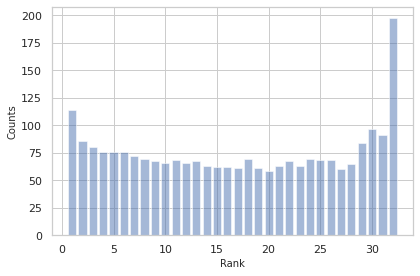

In [53]:
%autoreload
thresh=0.1
threshstr = str(thresh).replace('.','p')
nbins=32
rank = reliability.Talagrand(thresh,nbins)

#tlist = [7,8,9]
#for tii in [2,3,4,5,6]:
for tii in tlist:
    volcat = aeval.volcat_avg_hash[tii]
    forecast = aeval.cdump_hash[tii]*aeval.concmult
    dfin = rank.add_data_xra(volcat,forecast)
rank.plotrank()

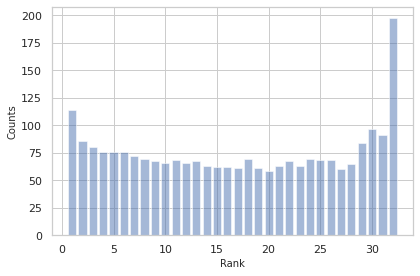

In [54]:
rank.plotrank()
plt.savefig(gdir + 'rank_{}_t{}_thresh{}{}'.format(tag,rel_time_str,threshstr,biastag))

In [55]:
rank.nonzerorow

[ens
 gec00    0.000000
 gep29    0.000000
 gep28    0.000000
 gep27    0.000000
 gep26    0.000000
 gep25    0.000000
 gep24    0.000000
 gep23    0.000000
 gep22    0.000000
 gep21    0.000000
 gep20    0.000000
 gep16    0.000000
 gep14    0.000000
 gep15    0.000000
 gep08    0.000000
 gep01    0.000000
 gep03    0.000000
 gep10    0.000000
 gep09    0.000000
 gep05    0.000000
 gep07    0.000000
 gep06    0.000000
 gep04    0.001270
 gep30    0.001298
 gep17    0.010377
 gep12    0.011684
 gep02    0.018076
 gep18    0.018108
 gep19    0.078727
 gep13    0.137727
 gep11    0.296329
 obs      2.680017
 Name: 893_451, dtype: float64,
 ens
 gec00    0.000000
 gep29    0.000000
 gep28    0.000000
 gep27    0.000000
 gep26    0.000000
 gep25    0.000000
 gep23    0.000000
 gep22    0.000000
 gep21    0.000000
 gep20    0.000000
 gep18    0.000000
 gep17    0.000000
 gep16    0.000000
 gep30    0.000000
 gep15    0.000000
 gep06    0.000000
 gep12    0.000000
 gep01    0.000000
 gep10  

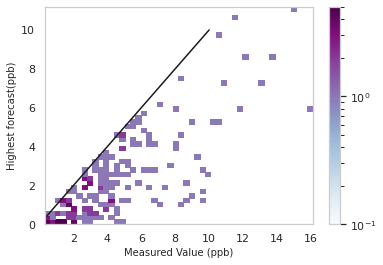

In [56]:
%autoreload
rank.check1()
plt.show()

# CDF matching to reduce bias

In [57]:
tii=8
ens=10
volcat = aeval.volcat_avg_hash[tii]
forecast = aeval.cdump_hash[tii]*aeval.concmult

In [58]:
from utilhysplit.evaluation import cdf_matching

In [59]:
%autoreload

In [60]:
rfc = forecast.isel(ens=ens).values.flatten()
robs = volcat.values.flatten()

In [61]:
%autoreload

thresh=0.1
thresh2, match = ensemble_tools.get_pixel_match(forecast,volcat,thresh)
match.dims

('ens', 'y', 'x')

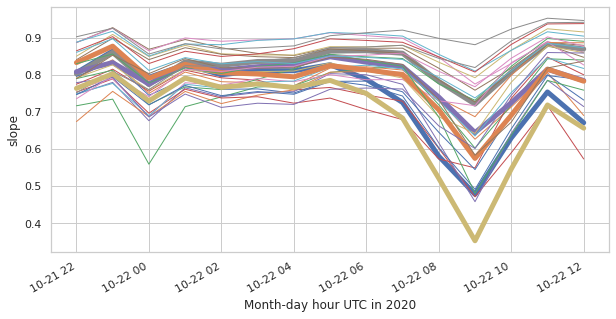

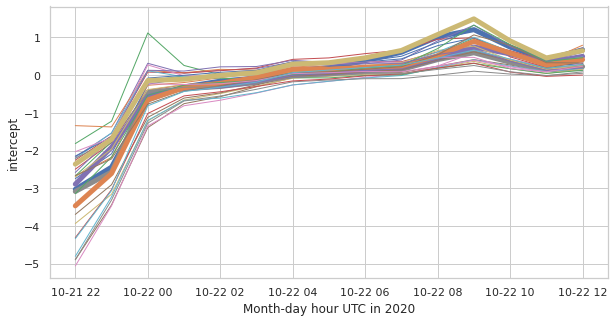

In [62]:
%autoreload
sns.set()
sns.set_style('whitegrid')
tii=8
ens=20
makeplots=False
polylist = []
total_polylist = []
timelist = []
fig = plt.figure(2,figsize=(10,5))
fig2 = plt.figure(1,figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
#ax3 = fig.add_subplot(3,1,3)

elist = []
tlist = []
slopes = []
intercepts = []
pmthresh = []
polyhash= {}

aeval.set_concmult(orig_mult)
biastag = ''

for ens in np.arange(0,30):
    polylist = []
    alist = []
    timelist = []
    for tii in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
        #print('time', tii)
      
        timelist.append(aeval.get_time(tii))
        volcat,forecast = aeval.get_pair(tii)
        thresh2, poly, fc = cdf_matching.cdf_match_volcat(forecast,volcat,thresh=0.01,ens=ens,scale=1,pfit=-1,makeplots=makeplots)
        #print(poly)
        polylist.append(poly)
        total_polylist.append(poly)
        tlist.append(aeval.get_time(tii))
        elist.append(ens)
        slopes.append(poly[0])
        intercepts.append(poly[1])
        pmthresh.append(thresh2)
    slope = list(zip(*polylist))[0]
    intercept = list(zip(*polylist))[1]
    slope2 = list(zip(*polylist))[-1]
    if ens%7==0: lw = 5
    else: lw=1
    ax1.plot(timelist,slope,linewidth=lw)
    ax2.plot(timelist,intercept,linewidth=lw)
    #ax3.plot(timelist,slope2,linewidth=lw)
    
polyhash['slope'] = slopes
polyhash['intercept'] = intercepts
polyhash['time'] = tlist
polyhash['ens'] = elist
polyhash['pmthresh'] = pmthresh
dfcdf = pd.DataFrame.from_dict(polyhash)

fig.autofmt_xdate()
slope = list(zip(*total_polylist))[0]
slope2 = list(zip(*total_polylist))[-1]
intercept = list(zip(*total_polylist))[1]
#print(np.mean(slope),np.mean(intercept))
#ax1.plot([timelist[0],timelist[-1]], [np.mean(slope),np.mean(slope)],'--k',linewidth=5)
plt.sca(ax1)
ax1.set_ylabel('slope')
plt.savefig(gdir + 'cdfmatch_slope_{}{}.png'.format(tag,biastag))
plt.sca(ax2)
ax2.set_xlabel('Month-day hour UTC in 2020')
ax2.set_ylabel('intercept')
ax1.set_xlabel('Month-day hour UTC in 2020')
plt.savefig(gdir + 'cdfmatch_intercept_{}{}.png'.format(tag,biastag))
#plt.show()
#plt.plot(slope,slope2,'k.')

0.7965397288439071 -1.6349193710284922


<ipython-input-63-730f10cbfae4>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tem = tem[dfcdf['time']==time]


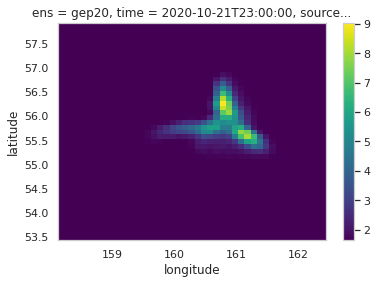

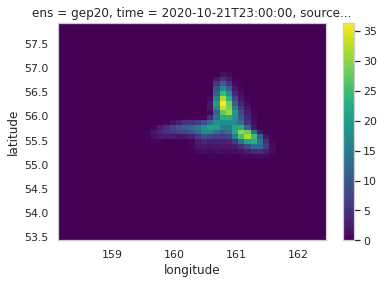

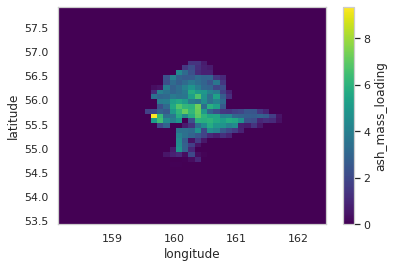

In [63]:
ens=20
tii=3
time = aeval.get_time(tii)
tem = dfcdf[dfcdf['ens']==ens]
tem = tem[dfcdf['time']==time]
tem
volcat,forecast = aeval.get_pair(tii)
forecast=forecast.isel(ens=ens)
slope = tem['slope'].values[0]
b = tem['intercept'].values[0]
pmthresh = tem['pmthresh']
print(slope,b)
f2 = forecast*[1-slope] -b
f2 = xr.where(f2>0,f2,0)
f2.plot.pcolormesh(x='longitude',y='latitude')
plt.show()
forecast.plot.pcolormesh(x='longitude',y='latitude')
plt.show()
volcat.plot.pcolormesh(x='longitude',y='latitude')

In [64]:
dfcdf = pd.DataFrame.from_dict(polyhash)

In [65]:
a = np.array([1,2,3,4,5])
b = [2,3,4]
a[len(a)-len(b):]

array([3, 4, 5])

In [66]:
aeval.get_time(14)

Timestamp('2020-10-22 10:00:00')

2020-10-21 23:00:00


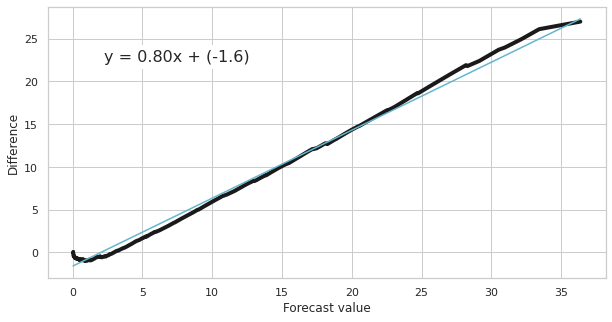

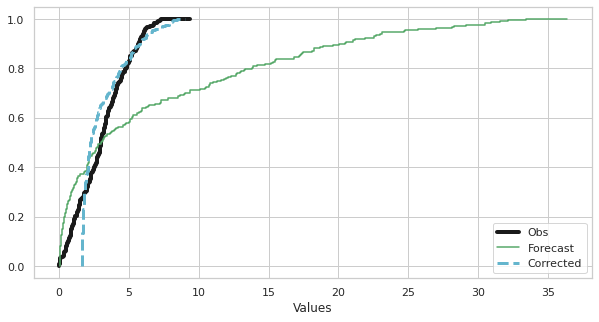

[ 0.79653973 -1.63491937]
<xarray.DataArray (dim_0: 1)>
array([0.03849901])
Dimensions without coordinates: dim_0


In [67]:
%autoreload
sns.set()
sns.set_style('whitegrid')
tii=3
print(aeval.get_time(tii))
ens=20
makeplots=True
aeval.set_concmult(orig_mult)
biastag = ''
volcat,forecast = aeval.get_pair(tii)
pmthresh, poly, fc = cdf_matching.cdf_match_volcat(forecast,volcat,thresh=0.01,ens=ens,scale=1,pfit=1,makeplots=makeplots,
                                         figname=gdir + 'cdfmatch{}_ens{}_time{}'.format(tag,ens,tii),
                                         figsize=(10,5))

print(poly)
print(pmthresh)

# Fit line through matched obervations and forecast to get scaling

6816
6816
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
FIT [-0.12302237  0.79625104]


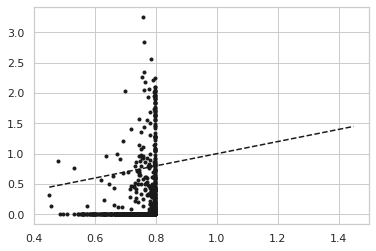

Text(0, 0.5, 'Observations')

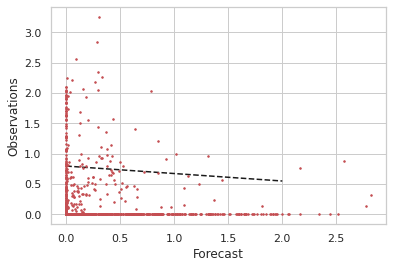

In [68]:
print(len(rfc))
print(len(robs))
newdata = list(zip(rfc,robs))
thresh = 0.05
newdata = [x for x in newdata if x[0]>thresh and x[1]>thresh]
newdata = list(zip(*newdata))

rfc2 = np.array(newdata[0])
robs2 = np.array(newdata[1])
print(rfc)
print(robs)
rfit = cdf_matching.apply_polyfit(rfc2,robs2)
newrfc = rfc*rfit[0]+rfit[1]
#newrfc = rfc*rfit[0]
print('FIT', rfit)
plt.plot(newrfc,robs,'k.')

xvals = np.arange(np.min(newrfc),np.max(newrfc)+1)
yvals = xvals
plt.plot(xvals,yvals,'--k')
plt.show()

xvals = np.arange(0,np.max(rfc))
yvals = rfit[0]*xvals + rfit[1]
plt.plot(xvals,yvals,'--k')
plt.plot(rfc,robs,'r.',MarkerSize=3)
plt.xlabel('Forecast')
plt.ylabel('Observations')

# This is a test of the polyfit

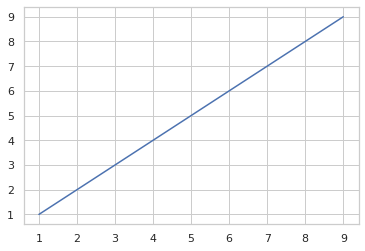

In [69]:
# define rfc as short array
# define robs as a function of rfc
rfc = np.array([0,1,2,3,4])
robs = 2*rfc + 1
# create the fit
rfit = cdf_matching.apply_polyfit(rfc,robs)
newrfc = rfc*rfit[0]+rfit[1]
plt.plot(newrfc,robs)

[2. 1.]


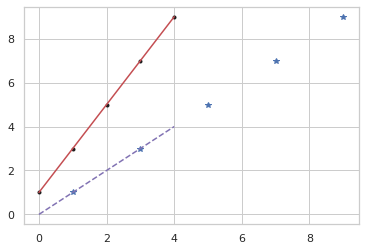

In [70]:
# plot the original relationship
plt.plot(rfc,robs,'k.')
x = np.array([0,1,2,3,4])
y = rfit[0]*x + rfit[1]
# plot the fit 
plt.plot(x,y,'-r')
print(rfit)
# convert the forecast to the obs and plot the obs
plt.plot(rfc*rfit[0]+rfit[1],robs, 'b*')
plt.plot(x,x,'--m')

# For testing CalcScores functions

In [71]:
%autoreload
testscores = plume_stat.CalcScores(volcat.fillna(0),forecast.fillna(0),threshold=0.1,probabilistic=False)
tframe = testscores.get_contingency_table(multi=True)

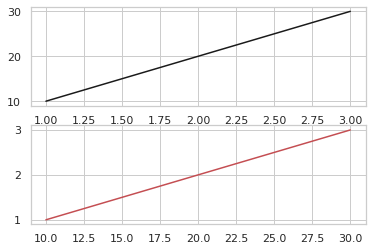

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
x = [1,2,3]
y = [10,20,30]
ax1.plot(x,y,'-k')
ax2.plot(y,x,'-r')

plt.show()

In [73]:
vset = aeval.get_volcat(dlist[0])

(55.0, 59.0)

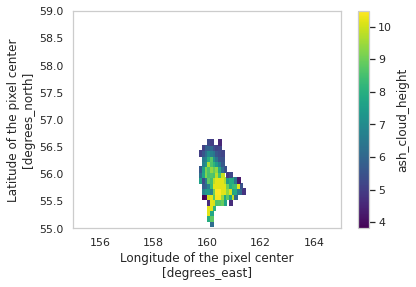

In [74]:
vset.ash_cloud_height.max(dim='time').plot.pcolormesh(x='longitude',y='latitude')
ax = plt.gca()
ax.set_xlim(155,165)
ax.set_ylim(55,59)

(54.0, 59.0)

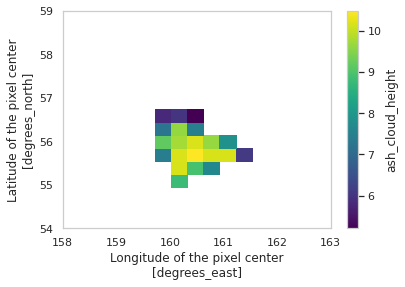

In [75]:
test = vset.ash_cloud_height.max(dim='time')
ccc = 3
test2 = test.coarsen(x=ccc,boundary='trim').max()
test2 = test2.coarsen(y=ccc,boundary='trim').max()
test2.plot.pcolormesh(x='longitude',y='latitude')
ax = plt.gca()
ax.set_xlim(158,163)
ax.set_ylim(54,59)

(215, 379) (215, 379) (215, 379)
61.07819175720215 179.98533630371094 10.48
39.678110122680664 -179.91466522216797 -1.0


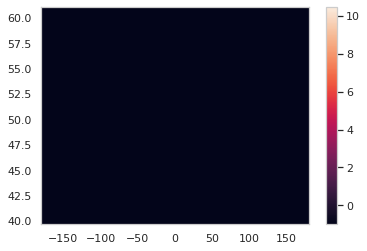

In [76]:
np.max(test.fillna(0).values)
lat = test.latitude.values
lon = test.longitude.values
vals = test.fillna(-1).values
print(lat.shape,lon.shape,vals.shape)
print(np.max(lat),np.max(lon),np.max(vals))
print(np.min(lat),np.min(lon),np.min(vals))
cb = plt.pcolormesh(lon,lat,vals)
plt.colorbar(cb)

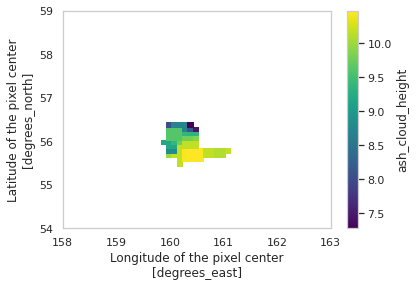

(54.0, 59.0)

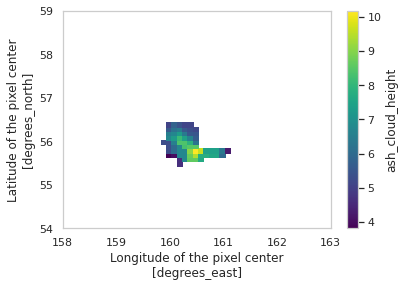

In [77]:
test4 = test.rolling(x=3,center=True).max()
test4 = test4.rolling(y=3,center=True).max()
test4.plot.pcolormesh(x='longitude',y='latitude')
ax = plt.gca()
ax.set_xlim(158,163)
ax.set_ylim(54,59)
plt.show()
test4 = test.rolling(x=3,center=True).min()
test4 = test4.rolling(y=3,center=True).min()
test4.plot.pcolormesh(x='longitude',y='latitude')
ax = plt.gca()
ax.set_xlim(158,163)
ax.set_ylim(54,59)

In [78]:
def plotest(testin):
    testin.plot.pcolormesh(x='longitude',y='latitude')
    
    ax = plt.gca()
    ax.set_xlim(158,163)
    ax.set_ylim(54,59)
    plt.show()
    print('max',np.max(testin.values))
    plt.pcolormesh(testin.values)
    ax = plt.gca()
    #ax.set_xlim(158,163)
    #ax.set_ylim(54,59)
    plt.show()

In [79]:
1.5e4 * 0.20

3000.0